Students:

Sahar Israel - 205654536

Avi Bechavod - 200675981

Harel Yadaan - 207331125

video: [Edit]

**Pretrained Pytorch face detection (MTCNN) and facial recognition (InceptionResnet) models**

The following example illustrates how to use the facenet_pytorch python package to perform face detection and tracking on an image dataset using MTCNN.

0. **Import project from github to get access to the datasets:**

In [ ]:
# With pip:
!pip install facenet-pytorch

# or clone this repo, removing the '-' to allow python imports:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

#install mmcv
!pip install mmcv

fatal: destination path 'facenet_pytorch' already exists and is not an empty directory.


# ***Face detection and recognition inference pipeline***

1. **Import models:**

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

**2**.**Determine if an nvidia GPU is available:**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


**3.Define MTCNN module:**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.


In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

**4.Define Inception Resnet V1 module:**

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to eval mode.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

**5.Define a dataset and data loader:**

We add the idx_to_class attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/facenet_pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**6.Perfom MTCNN facial detection:**

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The MTCNN forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have MTCNN return all detected faces, set keep_all=True when creating the MTCNN object above

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


**7.Calculate image embeddings:**

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

**8.Print distance matrix for classes:**

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  ...  paul_rudd  shea_whigham
angelina_jolie        0.000000        1.447480  ...   1.429847      1.399074
bradley_cooper        1.447480        0.000000  ...   1.013447      1.038684
kate_siegel           0.887728        1.313749  ...   1.388377      1.379655
paul_rudd             1.429847        1.013447  ...   0.000000      1.100503
shea_whigham          1.399074        1.038684  ...   1.100503      0.000000

[5 rows x 5 columns]


# ***Face tracking pipeline***

1. **Import models:**

In [ ]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

2. **Determine if an nvidia GPU is available:**


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


3. **Define MTCNN module:**


In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)


4. **Get a sample video:**

We begin by loading a video with some faces in it. The mmcv PyPI package by mmlabs is used to read the video frames (it can be installed with pip install mmcv). Frames are then converted to PIL images.


In [ ]:
video = mmcv.VideoReader('/content/w.wmv')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

#display.Video('/content/re.mp4', width=640)

5. **Run video through MTCNN:**

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [ ]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 199
Done


6. **Display detections:**


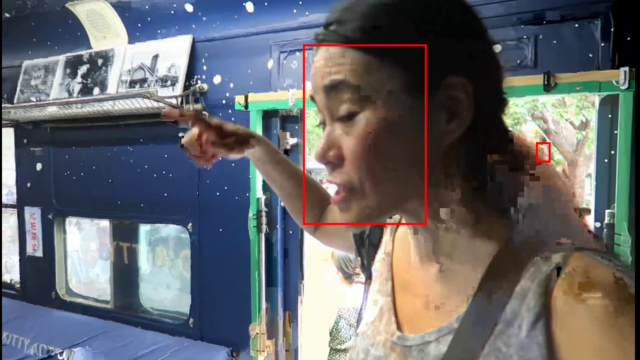

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while i<50:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

7. **Save tracked video:**

In [ ]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()